# Math 8803 HW2

## Problem 1 - Inter-spike Interval of a Poisson point process spike train

First, establishing some notation, we define the spike train point process as the Poisson point process $N(t)$. In other words, we interpret $N(t)$ as the number of spikes from time $0$ to $t$. Also, by the definition of a Poisson point process $N(0) = 0$. In other words, at time $t = 0$, we assume that no spikes have occurred. Furthermore, as given in the problem, the rate of this process is $r$.

Before extending to inter-spike interval times, let us first analyze the distribution of time of arrival. Then, we define $T_{1}$ as the random variable representing the time of the first arrival. A key intuition is that the probability the first arrival time is after time $t$ is equivalent to the probability that there is not arrival between time $0$ to time $t$. In other words:

$$\mathbb{P}(T_{1} > t) = \mathbb{P}(N_{t} = 0) = 1 - Poisson\_CDF(0; rt) = e^{-rt}$$

which means that $T_{1} \sim Exponential(r)$, i.e. the time of the first arrival follows an exponential distribution with rate $r$.

Now, let's look at the second arrival and see if we can generalize this distribution to times between spikes rather than between $0$ and the time of the first spike. Let $T_{2}$ be the time elapsed between the first arrival and the second arrival and let $t_{1}$ be the realized time of the first arrival. We are now interested in times $t_{2} > t_{1}$ where $t_{1} + t = t_{2}$ for some $t > 0$. Using the same argument as before, the probability that the second arrival is after time $t$ where $t_{2} + t > t_{1}$ is equivalent to the probability no spikes occur between the time interval $[t_{1}, t_{2}]$:

$$\mathbb{P}(T_{2} > t_{2} = t + t_{1}| T_{1} = t_{1}) = \mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0| T_{1} = t_{1}) $$

Another key fact we have to use about the Poisson process is that it is also memoryless, i.e. that previous arrivals shouldn't influence subsequent arrivals. Moreover, the sum of Poisson random variables is a Poisson random variable with a rate that is the sum of the rates, i.e. if $X_{i} \sim Poisson(\mu_{i})$ for $i = 1, \ldots, n$ then $X_{1} + \ldots + X_{n} \sim Poisson(\mu_{1} + \ldots + \mu_{n})$. Thus:

\begin{align*}
\mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0| T_{1} = t_{1}) &= \mathbb{P}(N_{t_{2}} - N_{t_{1}} = 0) \\
 &= 1 - Poisson\_CDF(0; r(t_{2} - t_{1})) \\
 &= e^{-r((t + t_{1}) - t_{1})} = e^{-rt}
\end{align*}

This argument can be inductively generalized for random variables $T_{i}$ to $T_{i + 1}$ which means that the inter-spike interval follows an exponential distribution. Specifically, using the notation given in the problem, the mean of the exponential distribution is $r$ and if we are interested in finding the probability at inter-spike interval length $\delta T$ we get:

$$\mathbb{P}(\delta t) = Exponential\_PDF(\delta t; r) = re^{-r\delta t}$$


## Problem 2

## (a) Izhekevich Model

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def prob_m_exc(N_exc, r_exc, timestep):
	return np.random.binomial(N_exc, r_exc * timestep)

def prob_m_inh(N_inh, r_inh, timestep):
	return np.random.binomial(N_inh, r_inh * timestep)

def n_inh(t1_inh, t2_inh):
	term1 = np.power((t2_inh / t1_inh), t2_inh / (t1_inh - t2_inh))
	term2 = np.power((t2_inh / t1_inh), t1_inh / (t1_inh - t2_inh))
	return np.power((term1 - term2), -1)

def n_exc(t1_exc, t2_exc):
	term1 = np.power((t2_exc / t1_exc), t2_exc / (t1_exc - t2_exc))
	term2 = np.power((t2_exc / t1_exc), t1_exc / (t1_exc - t2_exc))
	return np.power((term1 - term2), -1)


def ode_int_izhekevich_double_exponential_synapse(p, seed=123456789):
	np.random.seed(seed=seed) # Fix seed for reproducibility
	T = np.arange(0, p['t_max'] + p['delta_t'], p['delta_t'])
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))

	i_s_inh = np.zeros(len(T))
	i_s_exc = np.zeros(len(T))

	a_inh = np.zeros(len(T))
	b_inh = np.zeros(len(T))
	p_s_inh = np.zeros(len(T))

	a_exc = np.zeros(len(T))
	b_exc = np.zeros(len(T))
	p_s_exc = np.zeros(len(T))

	v[0] = p['c'] #mV
	V = v[0]
	u[0] = 0
	U = u[0] 

	A_inh = 0
	B_inh = 0

	N_inh = p['N_inh']
	r_inh = p['r_inh']
	tau_1_inh = p['tau_1_inh']
	tau_2_inh = p['tau_2_inh']
	Delta_P_s_inh = p['Delta_P_s_inh']
	G_inh = p['G_inh']
	E_syn_inh = p['E_syn_inh']

	A_exc = 0
	B_exc = 0

	N_exc = p['N_exc']
	r_exc = p['r_exc']
	tau_1_exc = p['tau_1_exc']
	tau_2_exc = p['tau_2_exc']
	Delta_P_s_exc = p['Delta_P_s_exc']
	G_exc = p['G_exc']
	E_syn_exc = p['E_syn_exc']

	m_inh_total = 0
	m_exc_total = 0

	for i in range(1, len(T)):
		t = T[i] #(i maps to t (i, t))

		## Forward euler of times between spikes in pre-synaptic neurons
		# Inhibitatory
		A_inh += p['delta_t'] * -A_inh / tau_1_inh
		B_inh += p['delta_t'] * -B_inh / tau_2_inh

		# Excitatory
		A_exc += p['delta_t'] * -A_exc / tau_1_exc
		B_exc += p['delta_t'] * -B_exc / tau_2_exc

		## When Presynaptic Neurons Spike
		# Inhibitatory
		m_inh = prob_m_inh(N_inh, r_inh, p['delta_t']) # TODO: Are we supposed to sample once or twice?
		m_inh_total += m_inh
		#m_inh_B = prob_m_inh(N_inh, r_inh, p['delta_t'])
		A_inh += m_inh * Delta_P_s_inh * (1 - p_s_inh[i - 1])
		B_inh += m_inh * Delta_P_s_inh * (1 - p_s_inh[i - 1])

		a_inh[i] = A_inh # = A_inh(t)
		b_inh[i] = B_inh # = B_inh(t)

		# Excitatory
		m_exc = prob_m_exc(N_exc, r_exc, p['delta_t'])
		m_exc_total += m_exc
		#m_exc_B = prob_m_exc(N_exc, r_exc, p['delta_t'])
		A_exc += m_exc * Delta_P_s_exc * (1 - p_s_exc[i - 1])
		B_exc += m_exc * Delta_P_s_exc * (1 - p_s_exc[i - 1])

		a_exc[i] = A_exc # = A_exc(t)
		b_exc[i] = B_exc # = B_exc(t)
		
		# Synaptic Current
		p_s_inh[i] = n_inh(tau_1_inh, tau_2_inh) * (a_inh[i] - b_inh[i]) # = p_s_inh(t)
		I_s_inh = G_inh * p_s_inh[i] * (V - E_syn_inh)

		p_s_exc[i] = n_exc(tau_1_exc, tau_2_exc) * (a_exc[i] - b_exc[i]) # = p_s_exc(t)

		I_s_exc = G_exc * p_s_exc[i] * (V - E_syn_exc)
		i_s_inh[i] = I_s_inh
		i_s_exc[i] = I_s_exc

		Is = I_s_exc + I_s_inh

		# Forward euler of Izhikevich Model
		V = V + p['delta_t'] * (0.04 * pow(V, 2) + 5*V + 140 - U - Is)
		U = U + p['delta_t'] * (p['a']*(p['b']*V-U))
		I[i] = Is
		if (V >= p['voltage_threshold']):
			v[i] = 30
			V = p['c']
			U = U + p['d']
		else:
			v[i] = V
		u[i] = U

	return v, T, I, i_s_inh, i_s_exc, m_inh_total, m_exc_total

In [17]:
parameters_2 = {
	"a": 10,
	"b": 0,
	"c": -82.7, # V_rest in mV
	"d": 0,
	"voltage_threshold": 30, # mv
	"delta_t": 0.01, #ms
	"t_max": 200, #ms
	"N_inh": 2, 
	"r_inh": 0.1,
	"tau_1_inh": 1,
	"tau_2_inh": 0.5,
	"Delta_P_s_inh": 0.1,
	"G_inh": 5,
	"E_syn_inh": -100, #mV
	"N_exc": 2, 
	"r_exc": 0.1,
	"tau_1_exc": 0.5,
	"tau_2_exc": 0.25,
	"Delta_P_s_exc": 0.1,
	"G_exc": 5,
	"E_syn_exc": 50, #mV
}

(20001,) (20001,) (20001,)


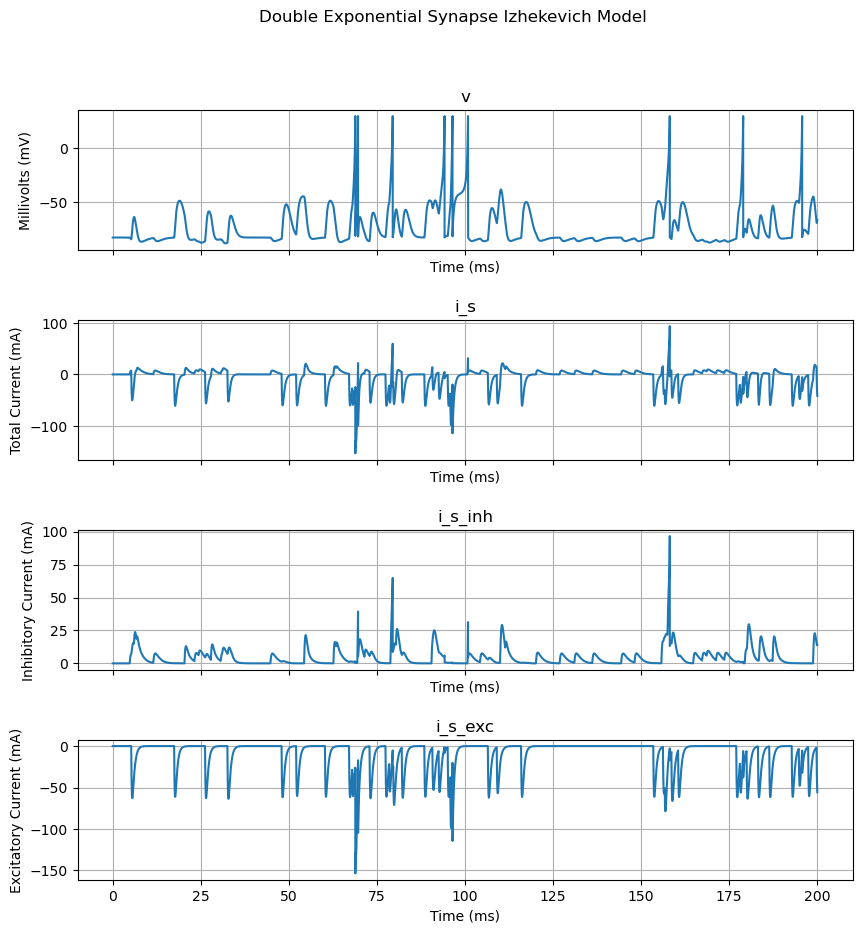

In [18]:
v, T, i, i_s_inh, i_s_exc, m_inh_total, m_exc_total = ode_int_izhekevich_double_exponential_synapse(parameters_2, seed=123456789)
print(T.shape, v.shape, i.shape)
fig, axs = plt.subplots(4, sharex=True, figsize=(10,10))
fig.suptitle("Double Exponential Synapse Izhekevich Model")

axs[0].plot(T, v)
axs[0].set_title('v')
axs[0].set(xlabel="Time (ms)", ylabel="Millivolts (mV)")
axs[0].grid()

axs[1].plot(T, i)
axs[1].set_title('i_s')
axs[1].set(xlabel="Time (ms)", ylabel="Total Current (mA)")
axs[1].grid()

axs[2].plot(T, i_s_inh)
axs[2].set_title('i_s_inh')
axs[2].set(xlabel="Time (ms)", ylabel="Inhibitory Current (mA)")
axs[2].grid()

axs[3].plot(T, i_s_exc)
axs[3].set_title('i_s_exc')
axs[3].set(xlabel="Time (ms)", ylabel="Excitatory Current (mA)")
axs[3].grid()

fig.subplots_adjust(hspace=0.5)


plt.show()

Based on the $v(t)$ plot above, it seems that smaller inter-spike intervals are more frequent that longer inter-spike intervals, which falls in line with the assumption that inter-spike intervals are exponentially distributed. Furthermore, it looks like there are $10$ spikes overall during the interval, which leads to a firing rate of $0.05$ (Spikes/ms), below the firing rates of both the excitatory and inhibitatory neurons. Moreover, there are several instances where the voltage potential rises, but does not reach the threshold, and thus does not spike.

## (b) Spike statistics

In [19]:
SECT_LENGTH = 20 #ms
INDEX_LENGTH = int(SECT_LENGTH / parameters_2['delta_t'])
print(INDEX_LENGTH, v.shape)

2000 (20001,)


In [20]:
bins = []
for idx in range(0, v.shape[0], INDEX_LENGTH):
	bins.append(v[idx:idx+INDEX_LENGTH])
bins.pop() # Last bin is a single timestep
print(len(bins))
print(bins[len(bins) - 1].shape)

10
(2000,)


In [21]:
num_of_spikes = np.zeros(len(bins))
for bin_idx in range(len(bins)):
	counts = (bins[bin_idx] == 30.0).sum()
	num_of_spikes[bin_idx] = counts # Assume a spike is whenever v(t) hits 30
print("Average Spikes Per Bin: ", np.mean(num_of_spikes))
print("Variance of Spikes Per Bin:", np.var(num_of_spikes))

Average Spikes Per Bin:  0.9
Variance of Spikes Per Bin: 0.89


In [22]:
spike_indices = (v == 30).nonzero()[0]
print(spike_indices.shape)

isi = []
for i in range(spike_indices.shape[0]):
	if i == 0: # First spike
		isi.append(spike_indices[i] * parameters_2['delta_t'])
	else:
		isi.append((spike_indices[i] - spike_indices[i-1]) * parameters_2['delta_t'])

isi = np.array(isi)
print(isi.shape)

(9,)
(9,)


Text(0.5, 1.0, 'Inter-spike Interval Length')

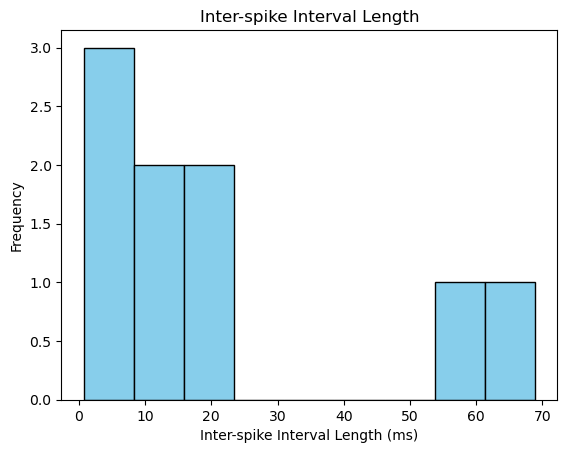

In [23]:
plt.hist(isi, bins=9, color='skyblue', edgecolor='black')
plt.xlabel('Inter-spike Interval Length (ms)')
plt.ylabel('Frequency')
plt.title('Inter-spike Interval Length')

In [24]:
print("Total number of m_exc:", m_exc_total, "Total number of m_inh:", m_inh_total)

print("Actual r_exc rate:", (m_exc_total/(parameters_2['t_max'] * parameters_2['N_exc'])), "(Spikes/ms)")
print("Actual r_inh rate:", (m_inh_total/(parameters_2['t_max'] * parameters_2['N_inh'])), "(Spikes/ms)")

Total number of m_exc: 40 Total number of m_inh: 42
Actual r_exc rate: 0.1 (Spikes/ms)
Actual r_inh rate: 0.105 (Spikes/ms)


In [25]:
# Monte Carlos Simulation
def mc_simulation(parameters, iters):
	iters = iters
	m_inh_total_mc = np.zeros(iters)
	m_exc_total_mc = np.zeros(iters)
	num_of_spikes_mc = np.zeros(iters)

	for seed in range(iters):
		v, _, _, _, _, m_inh_total_mc[seed], m_exc_total_mc[seed] = ode_int_izhekevich_double_exponential_synapse(parameters, seed=seed)
		num_of_spikes_mc[seed] = (v == 30).sum()

	print("average num of spikes:", num_of_spikes_mc.mean())
	print("Firing rate:", num_of_spikes_mc.mean() / parameters_2['t_max'] , ("Spike/ms"))
	print("average actual r_exc rate:", m_exc_total_mc.mean() / (parameters['t_max'] * parameters['N_exc']))
	print("average actual r_ing rate:", m_inh_total_mc.mean() / (parameters['t_max'] * parameters['N_inh']))
	return num_of_spikes_mc

num_spikes_mc = mc_simulation(parameters_2, 100)

average num of spikes: 10.78
Firing rate: 0.053899999999999997 Spike/ms
average actual r_exc rate: 0.100975
average actual r_ing rate: 0.098375


# Problem 3

## (a) Only excitatory input

In [26]:
parameters_3a = {
	"a": 10,
	"b": 0,
	"c": -82.7, # V_rest in mV DIFF
	"d": 0,
	"voltage_threshold": 30, # mv
	"delta_t": 0.01, #ms
	"t_max": 20000, #ms DIFF
	"N_inh": 100, # DIFF
	"r_inh": 0.1,
	"tau_1_inh": 1,
	"tau_2_inh": 0.5,
	"Delta_P_s_inh": 0.1,
	"G_inh": 0, # DIFF
	"E_syn_inh": -82.7, #mV # DIFF
	"N_exc": 100, # DIFF 
	"r_exc": 0.1,
	"tau_1_exc": 0.5,
	"tau_2_exc": 0.25,
	"Delta_P_s_exc": 0.1,
	"G_exc": 0.4, # DIFF
	"E_syn_exc": 50, #mV
}

In [27]:
v, T, i, _, _, m_inh_total, m_exc_total = ode_int_izhekevich_double_exponential_synapse(parameters_3a, seed=123456789)
print(T.shape, v.shape, i.shape)

(2000001,) (2000001,) (2000001,)


In [28]:
SECT_LENGTH = 20 #ms
INDEX_LENGTH = int(SECT_LENGTH / parameters_3a['delta_t'])
bins = []
for idx in range(0, v.shape[0], INDEX_LENGTH):
	bins.append(v[idx:idx+INDEX_LENGTH])
bins.pop() # Last bin is a single timestep
print(len(bins))
print(bins[len(bins) - 1].shape)

num_of_spikes = np.zeros(len(bins))
for bin_idx in range(len(bins)):
	counts = (bins[bin_idx] == 30.0).sum()
	num_of_spikes[bin_idx] = counts # Assume a spike is whenever v(t) hits 30
print("Average Spikes Per Bin: ", np.mean(num_of_spikes))
print("Variance of Spikes Per Bin:", np.var(num_of_spikes))

print("Average Rate Per Bin: ", np.mean(num_of_spikes / SECT_LENGTH))
print("Variance of Rate Per Bin:", np.var(num_of_spikes / SECT_LENGTH))

1000
(2000,)
Average Spikes Per Bin:  3.862
Variance of Spikes Per Bin: 0.290956
Average Rate Per Bin:  0.19310000000000002
Variance of Rate Per Bin: 0.0007273900000000003


(3862,)
(3862,)


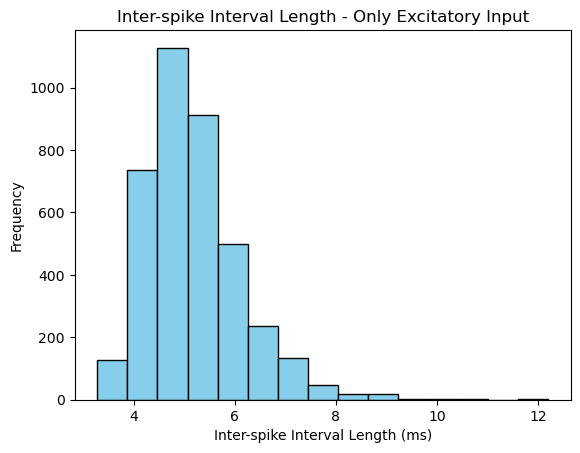

(15,) (16,)


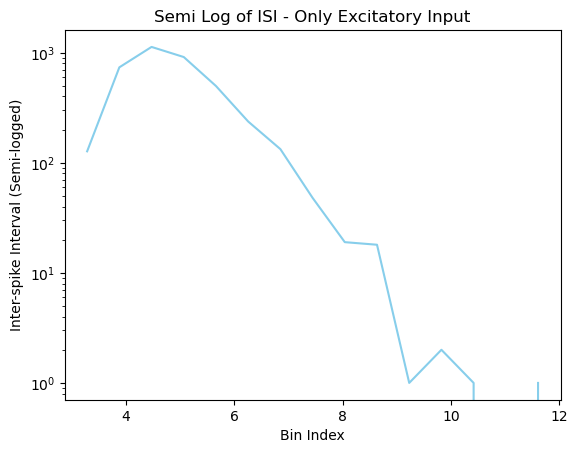

In [29]:
spike_indices = (v == 30).nonzero()[0]
print(spike_indices.shape)

isi = []
for i in range(spike_indices.shape[0]):
	if i == 0: # First spike
		isi.append(spike_indices[i] * parameters_2['delta_t'])
	else:
		isi.append((spike_indices[i] - spike_indices[i-1]) * parameters_2['delta_t'])

isi = np.array(isi)
print(isi.shape)

n, bins, hist = plt.hist(isi, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Inter-spike Interval Length (ms)')
plt.ylabel('Frequency')
plt.title('Inter-spike Interval Length - Only Excitatory Input')
plt.show()

print(n.shape, bins.shape)

plt.semilogy(bins[:-1], n, color='skyblue')
plt.xlabel('Bin Index')
plt.ylabel('Inter-spike Interval (Semi-logged)')
plt.title('Semi Log of ISI - Only Excitatory Input')
plt.show()

In this case, the firing of the neuron is almost twice that of the excitatory neurons driving it, i.e. approximately $1.9$ (Spikes/ms). Given that there are several time bins, the variance is extremely low compared to the mean (a consequence of the central limit theorem) which increases the certainty of this sampled mean. Furthermore, the inter-spike interval distribution is NOT consistent with a Poisson distribution because if we were to plot the semi log plot of the interspike intervals, the decrease is non-linear as bin index increases. In comparison with Figures 2, in Shadlen and Newsome 1998, which have different parameters of 0.05 firing rate and epochs of 100 ms, the output seems more consistent with figures B and C, which also have little inhibitatory input. For Figure $4$, it seems the ISI distribution is not exponential as demonstrated by the semi log plot and does not match the solid model curve. This also means the ISI distribution differs from Figure 14 E. 

## (b) - Balanced Excitatory and Inhibitory input

In [30]:
parameters_3b = {
	"a": 10,
	"b": 0,
	"c": -82.7, # V_rest in mV DIFF
	"d": 0,
	"voltage_threshold": 30, # mv
	"delta_t": 0.01, #ms
	"t_max": 20000, #ms DIFF
	"N_inh": 100, # DIFF
	"r_inh": 0.1,
	"tau_1_inh": 1,
	"tau_2_inh": 0.5,
	"Delta_P_s_inh": 0.1,
	"G_inh": 9, # DIFF
	"E_syn_inh": -82.7, #mV # DIFF
	"N_exc": 100, # DIFF 
	"r_exc": 0.1,
	"tau_1_exc": 0.5,
	"tau_2_exc": 0.25,
	"Delta_P_s_exc": 0.1,
	"G_exc": 20, # DIFF
	"E_syn_exc": 50, #mV
}

In [31]:
v, T, i, _, _, m_inh_total, m_exc_total = ode_int_izhekevich_double_exponential_synapse(parameters_3b, seed=123456789)
print(T.shape, v.shape, i.shape)

(2000001,) (2000001,) (2000001,)


In [32]:
SECT_LENGTH = 20 #ms
INDEX_LENGTH = int(SECT_LENGTH / parameters_3a['delta_t'])
bins = []
for idx in range(0, v.shape[0], INDEX_LENGTH):
	bins.append(v[idx:idx+INDEX_LENGTH])
bins.pop() # Last bin is a single timestep
print(len(bins))
print(bins[len(bins) - 1].shape)

num_of_spikes = np.zeros(len(bins))
for bin_idx in range(len(bins)):
	counts = (bins[bin_idx] == 30.0).sum()
	num_of_spikes[bin_idx] = counts # Assume a spike is whenever v(t) hits 30
print("Average Spikes Per Bin: ", np.mean(num_of_spikes))
print("Variance of Spikes Per Bin:", np.var(num_of_spikes))

print("Average Rate Per Bin: ", np.mean(num_of_spikes / SECT_LENGTH))
print("Variance of Rate Per Bin:", np.var(num_of_spikes / SECT_LENGTH))

1000
(2000,)
Average Spikes Per Bin:  2.585
Variance of Spikes Per Bin: 6.266775
Average Rate Per Bin:  0.12925
Variance of Rate Per Bin: 0.015666937500000002


(2585,)
(2585,)


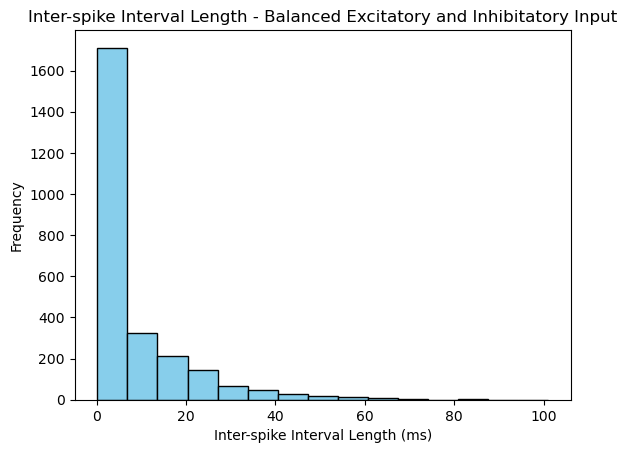

(15,) (16,)


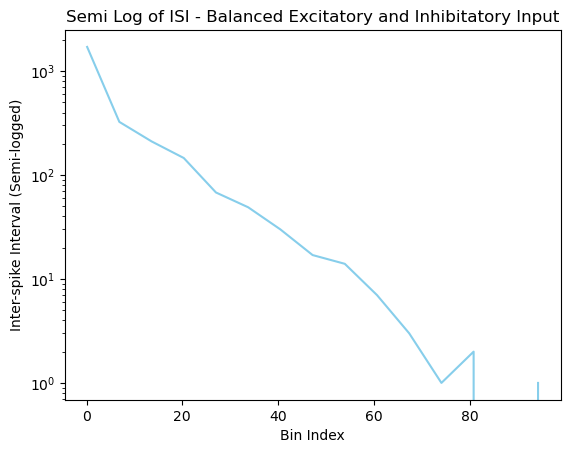

In [33]:
spike_indices = (v == 30).nonzero()[0]
print(spike_indices.shape)

isi = []
for i in range(spike_indices.shape[0]):
	if i == 0: # First spike
		isi.append(spike_indices[i] * parameters_2['delta_t'])
	else:
		isi.append((spike_indices[i] - spike_indices[i-1]) * parameters_2['delta_t'])

isi = np.array(isi)
print(isi.shape)

n, bins, hist = plt.hist(isi, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Inter-spike Interval Length (ms)')
plt.ylabel('Frequency')
plt.title('Inter-spike Interval Length - Balanced Excitatory and Inhibitatory Input')
plt.show()

print(n.shape, bins.shape)

plt.semilogy(bins[:-1], n, color='skyblue')
plt.xlabel('Bin Index')
plt.ylabel('Inter-spike Interval (Semi-logged)')
plt.title('Semi Log of ISI - Balanced Excitatory and Inhibitatory Input')
plt.show()

On the other hand, the firing rate of the simulated neuron here is much closer to that of the neurons driving it, at around $0.13$ (Spikes/ms). Though the variance of this estimation is magnitudes higher than the rate with only excitatory input, so there seems to be more variation in spike rate. Plotting the histogram of the inter-spike intervals and the corresponding semi-log plot, notice that the semi-log plot shows a negative linear relationship as the bin index increases, which is consistent with exponential decay. Thus spiking should look like figures F and G in Figure 2, and the inter-spike interval distribution resembles the distribution from Figure 4.
Additionally, the spiking and inter-spike interval distribution look similar to that of figures D and E in 14.